In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve, accuracy_score, auc
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
pd.set_option("display.max_rows", None)
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import k_means

In [133]:
metadata = pd.read_csv("metadata.csv",header=0,index_col=0)
microbiome = pd.read_csv("microbiome.csv",header=0,index_col=0)
metabolome = pd.read_csv("serum_lipo.csv",header=0,index_col=0)
diseases_to_categories = {'Metabolic_Syndrome':['1'],'Type_2_Diabetes':['3'],'Coronary_Artery_Disease':['4','5','6'],'Severe_Obesity':['2a','2b'],'Heart_Failure':['6','7'],'Healthy':['8']}

In [233]:
microbiome_train, microbiome_test, diseases_train, diseases_test = train_test_split(microbiome, metadata[['PATGROUPFINAL_C']], train_size=0.8)
train_idx = microbiome_train.index
test_idx  = microbiome_test.index
metabolome_train = metabolome.loc[train_idx]
metabolome_test  = metabolome.loc[test_idx]
microbiome_and_metabolome_train = pd.merge(metabolome_train, microbiome_train, left_index=True, right_index=True, how='inner')
microbiome_and_metabolome_test = pd.merge(metabolome_test, microbiome_test, left_index=True, right_index=True, how='inner')
metadata['Disease_status'] = metadata['PATGROUPFINAL_C'].apply(lambda x:0 if x == '8' else 1)
metadata['T2D'] = metadata['PATGROUPFINAL_C'].apply(lambda x:1 if x in diseases_to_categories['Type_2_Diabetes'] else 0)
metadata['CAD'] = metadata['PATGROUPFINAL_C'].apply(lambda x:1 if x in diseases_to_categories['Coronary_Artery_Disease'] else 0)
metadata['HF'] = metadata['PATGROUPFINAL_C'].apply(lambda x:1 if x in diseases_to_categories['Heart_Failure'] else 0)
metadata['SO'] = metadata['PATGROUPFINAL_C'].apply(lambda x:1 if x in diseases_to_categories['Severe_Obesity'] else 0)
metadata['MS'] = metadata['PATGROUPFINAL_C'].apply(lambda x:1 if x in diseases_to_categories['Metabolic_Syndrome'] else 0)
metadata_train = metadata.loc[train_idx]
metadata_test = metadata.loc[test_idx]
labels_train_all_diseases = metadata_train['Disease_status']
labels_test_all_diseases = metadata_test['Disease_status']
labels_train_T2D = metadata_train['T2D']
labels_test_T2D = metadata_test['T2D']
labels_train_CAD = metadata_train['CAD']
labels_test_CAD = metadata_test['CAD']
labels_train_HF = metadata_train['HF']
labels_test_HF = metadata_test['HF']
labels_train_SO = metadata_train['SO']
labels_test_SO = metadata_test['SO']
labels_train_MS = metadata_train['MS']
labels_test_MS = metadata_test['MS']
diseases_train_labels = [labels_train_T2D, labels_train_CAD, labels_train_HF, labels_train_SO, labels_train_MS]

In [214]:
metadata_test.head()

,PATGROUPFINAL_C,GENDER,AGE,CENTER_C,SMOKE,pa_work_2cl,DDS,Disease_status,T2D,CAD,HF,SO,MS
SampleID,,,,,,,,,,,,,
x30MCx1218,6,NaN,NaN,Danemark,NaN,NaN,NaN,1,0,1,1,0,0
x14MCx3348,8,0.0,63.0,France,0.0,1.0,NaN,0,0,0,0,0,0
x20MCx2038,3,0.0,76.0,Germany,0.0,1.0,21.0,1,1,0,0,0,0
x10MCx2294,1,1.0,46.0,France,0.0,1.0,10.0,1,0,0,0,0,1
x10MCx1844,2a,0.0,49.0,France,0.0,1.0,25.0,1,0,0,0,1,0


In [ ]:
import pandas as pd
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN

# Example data
df = pd.DataFrame({
    "feature1": [1, 2, 3, 4, 5, 6],
    "feature2": [10, 20, 30, 40, 50, 60],
    "description": ["a", "b", "c", "d", "e", "f"],
    "label": [0, 0, 0, 1, 1, 1]
})

# Keep only numeric features for resampling
X = df[["feature1", "feature2"]]
y = df["label"]

# Step 1: NearMiss undersampling
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X, y)
df_nm = df.loc[X_nm.index]  # Bring back irrelevant columns

# Step 2: ADASYN oversampling
ada = ADASYN()
X_ada, y_ada = ada.fit_resample(df_nm[["feature1", "feature2"]], y_nm)

# Final DataFrame with irrelevant columns preserved
df_final = pd.DataFrame(X_ada, columns=["feature1", "feature2"])
df_final["label"] = y_ada

# Merge back descriptions by index alignment
# ADASYN creates synthetic rows, so we must reattach descriptions carefully:
# Keep original for real rows, NaN for synthetic
df_final["description"] = None
df_final.loc[:len(df_nm)-1, "description"] = df_nm["description"].values

print(df_final)


In [221]:
def fix_imbalance(train_data, train_labels, metadata_tmp):
    sick_label = True
    healthy_label = False
    scale_factor = 1.75
    # Target: 90% healthy, 10% sick
    n_total = int(len(train_labels)*scale_factor)
    n_healthy_target = int(0.9 * n_total)
    n_sick_target = n_total - n_healthy_target
    print("Before under/over sampling:", Counter(train_labels))

    # Step 1: NearMiss v1 undersamples sick to its target count
    nm = NearMiss(version=1, n_neighbors=3, sampling_strategy={sick_label: n_sick_target})
    # Step 2: ADASYN oversamples healthy to its target count
    adasyn = ADASYN(sampling_strategy={healthy_label: n_healthy_target}, n_neighbors=5)
    pipeline = Pipeline([('nearmiss', nm),('adasyn', adasyn)])

    # train_data_balance, train_labels_balance = pipeline.fit_resample(train_data, train_labels)
    # print("After under/over sampling:", Counter(train_labels_balance))
    # return train_data_balance, train_labels_balance
    X_res, y_res = pipeline.fit_resample(train_data, train_labels)
    X_res, y_res = pipeline.fit_resample(train_data, train_labels)

    # Convert back to DataFrame/Series for alignment
    X_res = pd.DataFrame(X_res, columns=train_data.columns)
    y_res = pd.Series(y_res, name=train_labels.name or "label")

    # Number of rows in NearMiss output (before synthetic ADASYN samples)
    n_real = len(metadata_tmp.loc[train_data.index])

    # Real metadata: those from the NearMiss-kept rows
    real_meta = metadata_tmp.loc[train_data.index].reset_index(drop=True)

    # Synthetic metadata: placeholder values for new samples
    synthetic_count = len(X_res) - len(real_meta)
    synthetic_meta = pd.DataFrame(
        {col: "synthetic" for col in metadata_tmp.columns},
        index=range(synthetic_count)
    )

    # Combine
    metadata_res = pd.concat([real_meta, synthetic_meta], ignore_index=True)

    print("After under/over sampling:", Counter(y_res))

    return X_res, y_res, metadata_res

In [ ]:
microbiome_metabolome_train_balance, labels_train_balance, metadata_train_res = fix_imbalance(microbiome_and_metabolome_train, labels_train_all_diseases, metadata_train)
microbiome_metabolome_test_balance, labels_test_balance, metadata_test_res = fix_imbalance(microbiome_and_metabolome_test, labels_test_all_diseases, metadata_test)
microbiome_train_balance, microbiome_labels_train_balance, _ = fix_imbalance(microbiome_train, labels_train_all_diseases, metadata_train)
microbiome_test_balance, microbiome_labels_test_balance, _ = fix_imbalance(microbiome_test, labels_test_all_diseases, metadata_test)

Before under/over sampling: Counter({1: 974, 0: 132})
After under/over sampling: Counter({0: 1726, 1: 194})
Before under/over sampling: Counter({1: 239, 0: 38})
After under/over sampling: Counter({0: 437, 1: 49})
Before under/over sampling: Counter({1: 974, 0: 132})
After under/over sampling: Counter({0: 1726, 1: 194})
Before under/over sampling: Counter({1: 239, 0: 38})
After under/over sampling: Counter({0: 437, 1: 49})


In [ ]:
def run_random_forest(train_data, train_labels, test_data, test_labels, plot_title):
    model = RandomForestClassifier()
    model.fit(train_data,train_labels)
    importances = model.feature_importances_
    gini_df = pd.DataFrame({'Feature': train_data.columns,'Gini Importance': importances}).sort_values(by='Gini Importance', ascending=False)
    labels_probs = model.predict_proba(test_data)[:, 1]
    labels_pred = model.predict(test_data)
    correctness = labels_pred == test_labels
    confidence_df = pd.DataFrame({'Confidence score': labels_probs, 'Correct':correctness})
    precision, recall, _ = precision_recall_curve(test_labels, labels_probs)
    aupr = auc(recall, precision)
    # aupr = average_precision_score(test_labels, labels_probs)
    baseline = sum(test_labels) / len(test_labels)
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, label=f'AUPR = {aupr:.4f}')
    plt.hlines(baseline, 0, 1, colors='r', linestyles='dashed', label=f'Baseline = {baseline:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve '+plot_title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return confidence_df, gini_df

In [234]:
labels_train_1 = metadata_train_res['PATGROUPFINAL_C'].apply(lambda x:1 if x in ['3','2a','2b'] else 0)
labels_train_2 = metadata_train_res['PATGROUPFINAL_C'].apply(lambda x:1 if x in ['4','5','6','7'] else 0)
labels_train_3 = metadata_train_res['PATGROUPFINAL_C'].apply(lambda x:1 if x in ['1'] else 0)

In [226]:
# microbiome_only_res = run_random_forest(microbiome_train_balance, microbiome_labels_train_balance, microbiome_test_balance, microbiome_labels_test_balance, 'any disease, microbiome data only')
def remove_high_confidence_samples():
    microbiome_metabolome_res = run_random_forest(microbiome_metabolome_train_balance, labels_train_balance, microbiome_metabolome_test_balance, labels_test_balance, 'any disease, microbiome and metabolome data')
    confidence = microbiome_metabolome_res[0]
    x = 0.8
    high_confidence_samples = confidence[confidence["Confidence score"] >= x]
    # for high confidence- return prediction
    test = microbiome_metabolome_test_balance.drop(microbiome_metabolome_test_balance.iloc[high_confidence_samples.index,:].index, axis=0)
    labels = labels_test_balance.iloc[test.index]
    return test, labels

    # larger_count = (confidence["Confidence score"] >= x).sum()
    # smaller_count = (confidence["Confidence score"] < x).sum()
    # print("larger: ",larger_count)
    # print("smaller: ",smaller_count)
    # large_confidence_and_correct = ((confidence["Confidence score"] > x) & (confidence["Correct"] == True)).sum()
    # large_confidence_and_correct

In [227]:
def run_feature_selection(train_data, train_labels, test_data):
    model = lgb.LGBMClassifier(verbose=-1)
    model.fit(train_data,train_labels)
    selector = SelectFromModel(model, prefit=True)
    train_data_sel = selector.transform(train_data)
    test_data_sel = selector.transform(test_data)
    selected_features = train_data.columns[selector.get_support()]
    importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': train_data.columns,'Importance': importances}).sort_values(by='Importance', ascending=False)
    return selected_features

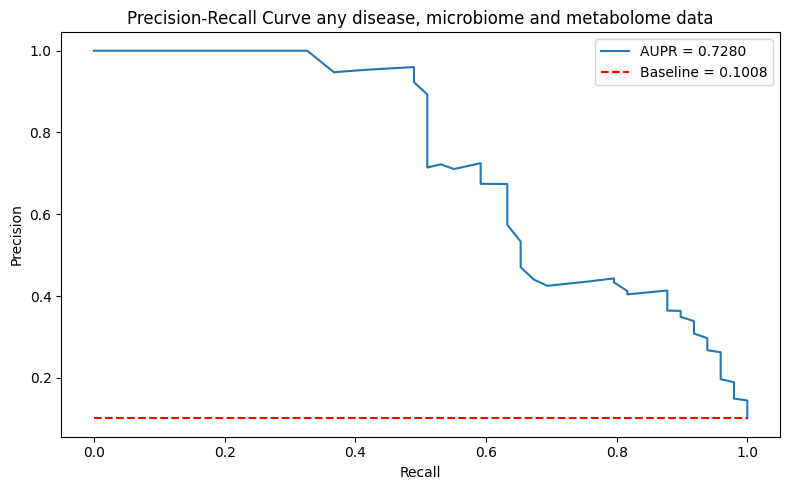

In [235]:
filtered = remove_high_confidence_samples()
microbiome_and_metabolome_test_filtered = filtered[0]
microbiome_and_metabolome_test_labels_filtered = filtered[1]
labels_test_1 = metadata_test_res['PATGROUPFINAL_C'].apply(lambda x:1 if x in ['3','2a','2b'] else 0).iloc[microbiome_and_metabolome_test_labels_filtered.index]
labels_test_2 = metadata_test_res['PATGROUPFINAL_C'].apply(lambda x:1 if x in ['4','5','6','7'] else 0).iloc[microbiome_and_metabolome_test_labels_filtered.index]
labels_test_3 = metadata_test_res['PATGROUPFINAL_C'].apply(lambda x:1 if x in ['1'] else 0).iloc[microbiome_and_metabolome_test_labels_filtered.index]
disease_groups_labels = {1:(labels_train_1, labels_test_1), 2:(labels_train_2, labels_test_2), 3:(labels_train_3, labels_test_3)}
def run_feature_selection_per_disease(disease_train_labels):
    microbiome_metabolome_labels_train_balance = labels_train_balance.copy()
    mask_sick = labels_train_balance == True
    microbiome_metabolome_labels_train_balance[mask_sick] = disease_train_labels.reset_index(drop=True)[mask_sick]
    return run_feature_selection(microbiome_metabolome_train_balance, microbiome_metabolome_labels_train_balance, microbiome_and_metabolome_test_filtered)

In [ ]:
run_feature_selection(microbiome_and_metabolome_train, labels_train_T2D, microbiome_and_metabolome_test)

In [230]:
diseases_groups = {'T2D':1,'SO':1,'CAD':2,'HF':2,'MS':3}
features_per_disease_group = {1:set(),2:set(),3:set()}
for disease_labels in diseases_train_labels:
    features = set(run_feature_selection_per_disease(disease_labels))
    features_per_disease_group[diseases_groups[disease_labels.name]] = features_per_disease_group[diseases_groups[disease_labels.name]].union(features)

In [258]:
def lgbm_per_disease_group(train_data, train_labels, test_data, test_labels, features):
    model = lgb.LGBMClassifier(verbose=-1)
    model.fit(train_data[features], train_labels)
    labels_probs = model.predict_proba(test_data[features])[:, 1]
    print(sum(test_labels) / len(test_labels))
    print(average_precision_score(test_labels, labels_probs))

In [252]:
def second_layer():
    for disease_group in [1,2,3]:
        train_labels, test_labels = disease_groups_labels[disease_group]
        features = sorted(features_per_disease_group[disease_group])
        lgbm_per_disease_group(microbiome_metabolome_train_balance, train_labels, microbiome_and_metabolome_test_filtered, test_labels, features)

In [259]:
second_layer()

0.2773109243697479
0.3571081179436511
0.1323529411764706
0.1442587578676237
0.07563025210084033
0.10959778147950475
